<a href="https://colab.research.google.com/github/daraadeniyi3116-create/ACCESS-6.0-SAP-Data-Science-Track/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np

from google.colab import drive
import os

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("Mounted!")
else:
    print("Drive is already mounted.")

Drive is already mounted.


### **Part 1**
---


## Feature Engineering

In [20]:
df = pd.read_csv('/content/Warehouse_and_Retail_Sales_Cleaned.csv')


# --- 1. Date Feature: Seasonality ---
# Instead of just using "Month" (which is just a number), I grouped them into Seasons.
# This helps the model capture behaviors like "Holiday Shopping" vs "Summer Break".
def get_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['MONTH'].apply(get_season)

# --- 2. Aggregated Feature: Total Volume ---
# The dataset splits sales into Retail and Warehouse.
# To understand true demand, I combined them.
df['Total_Sales'] = df['RETAIL SALES'] + df['WAREHOUSE SALES']

# --- 3. Advanced Feature: Relative Performance ---
# This is a key feature. It calculates the average sales for each Item Type (e.g., Wine, Beer),
# then compares this specific row to that average.
# 1.0 = Average performance.
# >1.0 = Outperforming its category.
item_type_means = df.groupby('ITEM TYPE')['Total_Sales'].transform('mean')
df['Relative_Performance'] = df['Total_Sales'] / (item_type_means + 1) # +1 avoids division by zero

df[['MONTH', 'Season', 'ITEM TYPE', 'Total_Sales', 'Relative_Performance']].head()

,MONTH,Season,ITEM TYPE,Total_Sales,Relative_Performance
0,1,Winter,WINE,2.00,0.179463
1,1,Winter,WINE,4.00,0.358927
2,1,Winter,BEER,1.00,0.005937
3,1,Winter,WINE,1.00,0.089732
4,1,Winter,WINE,0.82,0.073580


## Encoding Decisions

In [21]:
df.head()

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,TOTAL_SALES,RETAIL_RATIO,Season,Total_Sales,Relative_Performance
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0,2.00,0.000000,Winter,2.00,0.179463
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0,4.00,0.000000,Winter,4.00,0.358927
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0,1.00,0.000000,Winter,1.00,0.005937
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0,1.00,0.000000,Winter,1.00,0.089732
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0,0.82,0.998782,Winter,0.82,0.073580


I identified 4 columns containing text/non-numeric data. Here is the encoding strategy I will use for each:

* **Column:** "Season" & "ITEM TYPE"
    * **Decision: One-Hot Encoding**
    * **Reason:** These are **nominal categories** (they have no inherent order). "Spring" is not mathematically greater than "Winter," and "Wine" is not greater than "Beer." One-Hot Encoding creates a separate binary column for each category (e.g., "Season_Winter", "Item_Wine"), which allows the model to recognize them distinctively without assuming a false hierarchy.

* **Column:** "SUPPLIER"
    * **Decision: Label Encoding**
    * **Reason:** This column has **high cardinality** (hundreds of unique suppliers). Using One-Hot Encoding here would create hundreds of new columns (the "Curse of Dimensionality"), making the dataset massive and slow to train. Label Encoding is efficient because it assigns a unique integer to each supplier without changing the dataset's shape.

* **Column:** "ITEM DESCRIPTION"
    * **Decision: Label Encoding**
    * **Reason:** This column contains thousands of unique variations of text. One-Hot Encoding is impossible here due to the size. Label Encoding allows us to turn this text into numbers so we don't have to drop the column, allowing the model to potentially find patterns in specific item descriptions.

## Scaling Decisions

In [22]:
df.describe()

,YEAR,MONTH,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,TOTAL_SALES,RETAIL_RATIO,Total_Sales,Relative_Performance
count,307645.000000,307645.000000,307645.000000,307645.000000,307645.000000,307645.000000,307645.000000,307645.000000,307645.000000
mean,2018.438525,6.423862,7.024003,6.936465,25.294597,32.318600,0.429798,32.318600,0.927262
std,1.083061,3.461812,30.986095,30.237195,249.916798,266.486255,1.616856,266.486255,2.950824
min,2017.000000,1.000000,-6.490000,-38.490000,-7800.000000,-7800.000000,-104.210526,-7800.000000,-1.920301
25%,2017.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.078910
50%,2019.000000,7.000000,0.320000,0.000000,1.000000,2.680000,0.242332,2.680000,0.179463
75%,2019.000000,9.000000,3.260000,3.000000,5.000000,10.500000,0.994152,10.500000,0.629875
max,2020.000000,12.000000,2739.000000,1990.830000,18317.000000,19491.000000,830.000000,19491.000000,123.175603


**Columns to Scale**: RETAIL SALES, WAREHOUSE SALES, TOTAL_SALES, and Relative_Performance.

**Scaler Selected**: MinMaxScaler

**Reasoning**: I examined the df.describe() table and found a huge disparity in the ranges of my features:

- Categorical features (like the One-Hot encoded Seasons) are all 0 or 1.

- Date features (like Month) only range from 1 to 12.

- Sales features (like TOTAL_SALES), however, range from -7,800 up to 19,491.

If I feed this directly into a regression model, the model will treat the Sales columns as thousands of times more important than the Season or Month simply because the numbers are bigger. I will use MinMaxScaler to squeeze these large sales figures into a range of 0 to 1, ensuring they don't overpower the other features.

## Model Thinking

**Target Variable**: TOTAL_SALES

**Problem Type**: Regression.

**Reasoning**: I am trying to predict the exact volume of sales, which is a continuous numerical value (e.g., selling 50 units vs. 500 units). This is different from Classification, where I would be predicting a label like "High Performer" or "Low Performer." Since the output can be any number on a scale, and I have historical data to learn from.

### **Part 2**
---


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

In [24]:
df = pd.read_csv('/content/housing.csv')

##Initial Data Inspection

In [25]:
df.shape

(20640, 10)

In [26]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [28]:
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [29]:

print(f"Duplicates: {df.duplicated().sum()}")

Duplicates: 0


## Data Cleaning

In [30]:
# 1. Handle Missing Values
# We fill missing 'total_bedrooms' with the median because it's robust to outliers.
median_bedrooms = df['total_bedrooms'].median()
df['total_bedrooms'] = df['total_bedrooms'].fillna(median_bedrooms)

# 2. Drop Duplicates (if any exist)
df.drop_duplicates(inplace=True)

# 3. The "Type Fix" (Float -> Integer)
# These columns are counts, so they should be whole numbers.
cols_to_fix = ['total_rooms', 'total_bedrooms', 'population', 'households', 'housing_median_age']
for col in cols_to_fix:
    df[col] = df[col].astype(int)

# Verify Cleaning
print("✅ Cleaning Complete.")
print(f"Remaining Missing Values: {df.isnull().sum().sum()}")

✅ Cleaning Complete.
Remaining Missing Values: 0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20640 non-null  int64  
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


##Exploratory Data Analysis (EDA)


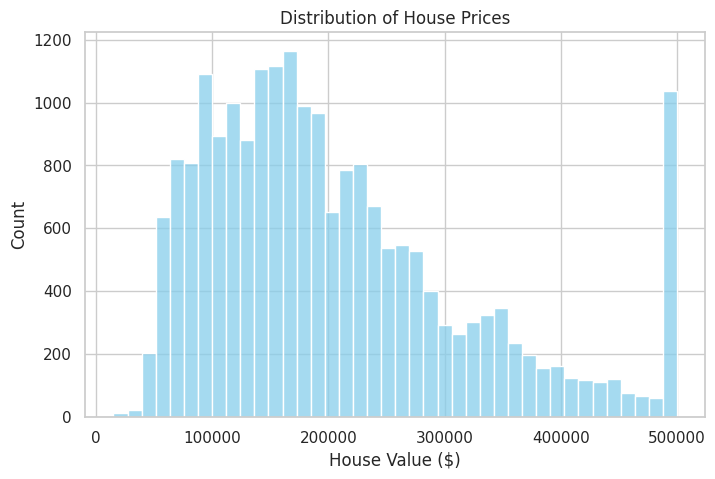

In [32]:
sns.set_theme(style="whitegrid")

# Visual 1: Histogram (Distribution of Prices)
plt.figure(figsize=(8, 5))
sns.histplot(df['median_house_value'], bins=40, color='skyblue')
plt.title('Distribution of House Prices')
plt.xlabel('House Value ($)')
plt.show()



#Insight
The distribution is right-skewed, showing that most houses in California are in the lower price range (100k - 200k). However, there is a massive, unnatural spike at exactly $500,000, which indicates that the data was likely 'capped' (censored) at this maximum value during collection.

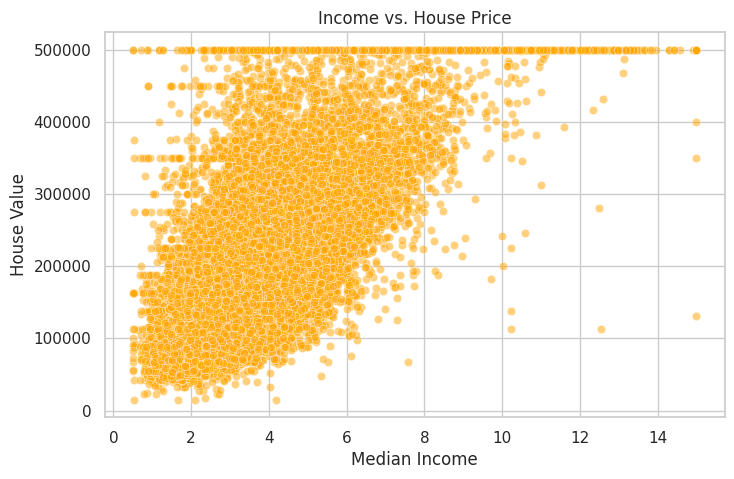

In [33]:
# Visual 2: Scatter Plot (Income vs Price)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='median_income', y='median_house_value', data=df, alpha=0.5, color='orange')
plt.title('Income vs. House Price')
plt.xlabel('Median Income')
plt.ylabel('House Value')
plt.show()


#Insight

There is a strong positive correlation between income and housing prices; as median income rises, house values consistently go up. The plot also confirms the data cap, appearing as a straight horizontal line at the $500,000 mark where prices stop increasing despite higher incomes

##Feature Engineering, Scaling and Encoding

## 3. Feature Engineering & Strategy

**New Features**
The raw data provided totals for entire districts, which isn't helpful for individual house prediction. I created "Per Household" ratios to normalize the data:
* "rooms_per_household": Average size of a home.
* "bedrooms_per_room": A proxy for layout quality/luxury.
* "population_per_household": A measure of crowding.

In [34]:
# Creating "Per Household" ratios to understand the real size of homes
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']



##1. **Identify columns for Encoding:**
* **Column:** "ocean_proximity"
* **Decision:** **One-Hot Encoding**.
* **Reason:** This is a nominal categorical variable (text values like "NEAR BAY", "INLAND") with no inherent mathematical order. One-Hot encoding converts these into binary columns so the model can process them without assuming a false hierarchy.

##2. **Identify columns for Scaling:**
* **Columns:** "total_rooms", "total_bedrooms", "population", "households", "median_income", "housing_median_age", "longitude", "latitude".
* **Decision:** **StandardScaler**.
* **Reason:** The dataset features have vastly different ranges. "median_income" is a small number (approx. 0–15), while "total_rooms" can reach up to 40,000. Without scaling, the model would be biased toward features with larger magnitudes, treating them as more important. Scaling centers all features around 0 with a standard deviation of 1.

##Model Recommendation

**Target**: median_house_value

**Problem Type**: Regression (Predicting a number).

**Model**: Random Forest Regressor. It is good at handling complex data where simple straight lines (Linear Regression) might not fit well.